## Install Dependencies and Import

In [ ]:
!pip install transformers
!pip install datasets
!pip install salesforce-lavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from datasets import load_dataset
from lavis.models import load_model_and_preprocess
from matplotlib import pyplot as plt

## Load Winoground and BLIP2-Qformer

In [ ]:
auth_token = "add your HF authentication token"
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset winoground downloaded and prepared to /root/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/72585f4d9cd5a28790bb9bc2adbdd45633f36dfbf85df529e0756e114e134285. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
# loads BLIP-2 pre-trained model
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain_vitL", is_eval=True, device=device)

100%|██████████| 555M/555M [00:17<00:00, 32.9MB/s]


100%|██████████| 699M/699M [00:38<00:00, 18.9MB/s]


## Feature Extraction and Cosine Similarity Score

In [ ]:
def get_cos_sim(caption, image):

  # Image pre-processing and text tokenization
  image = vis_processors["eval"](image).unsqueeze(0).to(device)
  text_input = txt_processors["eval"](caption)
  sample = {"image": image, "text_input": [text_input]}

  # get predictions
  features_image = model.extract_features(sample, mode="image")
  features_text = model.extract_features(sample, mode="text")
  score = (features_image.image_embeds_proj @ features_text.text_embeds_proj[:,0,:].t()).max()

  return score

## Visualize data and sanity check

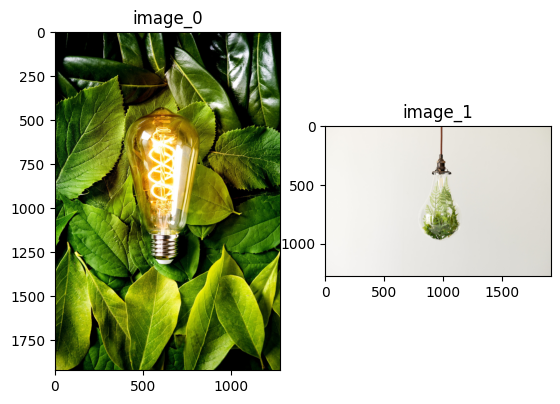

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants

 Image-Text match scores:

image_0, caption_0: tensor(0.4574, device='cuda:0')
image_0, caption_1: tensor(0.4642, device='cuda:0')
image_1, caption_0: tensor(0.3500, device='cuda:0')
image_1, caption_1: tensor(0.3458, device='cuda:0')


In [ ]:
ax1 = plt.subplot(1, 2, 1)
ax1.title.set_text('image_0')
plt.imshow(winoground[155]["image_0"].convert("RGB"))

ax2 = plt.subplot(1, 2, 2)
ax2.title.set_text('image_1')
plt.imshow(winoground[155]["image_1"].convert("RGB"))

plt.show()
print("caption_0:", winoground[155]["caption_0"])
print("caption_1:", winoground[155]["caption_1"])

# Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
output_c0_i0 = get_cos_sim(winoground[155]["caption_0"], winoground[155]["image_0"].convert("RGB"))
output_c1_i0 = get_cos_sim(winoground[155]["caption_1"], winoground[155]["image_0"].convert("RGB"))
output_c0_i1 = get_cos_sim(winoground[155]["caption_0"], winoground[155]["image_1"].convert("RGB"))
output_c1_i1 = get_cos_sim(winoground[155]["caption_1"], winoground[155]["image_1"].convert("RGB"))

print("\n Image-Text match scores:\n")
print("image_0, caption_0:", output_c0_i0)
print("image_0, caption_1:", output_c1_i0)
print("image_1, caption_0:", output_c0_i1)
print("image_1, caption_1:", output_c1_i1)

## Get image-caption scores from the whole dataset



In [ ]:
from tqdm import tqdm
winoground_clip_scores = []
for example in tqdm(winoground):
  # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
  score_c0_i0 = get_cos_sim(example["caption_0"], example["image_0"].convert("RGB"))
  score_c1_i0 = get_cos_sim(example["caption_1"], example["image_0"].convert("RGB"))
  score_c0_i1 = get_cos_sim(example["caption_0"], example["image_1"].convert("RGB"))
  score_c1_i1 = get_cos_sim(example["caption_1"], example["image_1"].convert("RGB"))

  winoground_clip_scores.append({"id" : example["id"], "c0_i0": score_c0_i0, "c0_i1": score_c0_i1, "c1_i0": score_c1_i0, "c1_i1": score_c1_i1})

100%|██████████| 400/400 [03:10<00:00,  2.10it/s]


# Define the text, image, and group metrics, and compute the overall performance of CLIP

In [ ]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

text_correct_count = 0
image_correct_count = 0
group_correct_count = 0
for result in winoground_clip_scores:
  text_correct_count += 1 if text_correct(result) else 0
  image_correct_count += 1 if image_correct(result) else 0
  group_correct_count += 1 if group_correct(result) else 0

denominator = len(winoground_clip_scores)
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)


text score: 0.3
image score: 0.1075
group score: 0.0825
